# Working with data matrices and analysis results

This notebook will show the most suitable commands to retrieve data from GrandPy object in different scenarios.

Throughout this notebook, we will be using GRAND-SLAM processed SLAM-seq data set from [Finkel et al. (2021)](https://www.nature.com/articles/s41586-021-03610-3). The data set contains time series (progressive labeling) samples from a human epithelial cell line (Calu3 cells); half of the samples were infedctes with SARS-CoV-2 for different periods of time. For more on these initial commands see the [Loading data](--) notebook.

In [1]:
import warnings
import pandas as pd
from scripts.regsetup import description

import grandpy as gp
from grandpy import ModeSlot

warnings.filterwarnings("ignore", category=UserWarning)

sars = gp.read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz", design=("Condition", "dur.4sU", "Replicate"), classify_genes_func=lambda df: gp.classify_genes(df, cg_name="viral"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file sars.tsv.gz was deleted after loading.


In [2]:
sars = sars.filter_genes()

# Data slots
Data is orgnaized in a grandPy object in slots:

In [3]:
sars.slots

['ntr', 'alpha', 'beta', 'count']

To learn more about metadata, see the [loading data notebook](). After loading GRAND-SLAM analysis results, the default slots are "count" (read counts), "ntr" (the new-to-total RNA ratio), "alpha" and "beta" (the parameters for the Beta approximation of the NTR posterior distribution). Each of these slots contains a gene x columns ( columns are either samples or cells, depending on whether your data is bulk or singel cell data) matrix of numeric values.

There is also a default slot, which is used by many functions as default parameter.

In [4]:
sars.default_slot

'count'

New slots are added by specific GrandPy functions such as `normalize()` or `normlaize_tpm()`, which by default, change the default slot. The default slot can also be set manually.

In [5]:
sars = sars.normalize()
sars.default_slot

'norm'

In [6]:
sars.with_default_slot("count")
sars.default_slot

'norm'

In [7]:
sars = sars.normalize_tpm(set_to_default = False)
sars.default_slot

'norm'

In [8]:
print(sars.with_default_slot("norm"))

GrandPy:
Read from C:\Users\finn3\AppData\Local\Temp\tmp_oyrxcro\sars.tsv.gz
9162 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'norm', 'tpm']
Available analyses: []
Available plots: {}
Default data slot: norm



There are also other GrandPy functions that add additional slots, but do not update the `default_slot` automatically:

In [9]:
sars = sars.compute_ntr_ci()
sars.default_slot

'norm'

In [10]:
sars.slots

['ntr', 'alpha', 'beta', 'count', 'norm', 'tpm', 'lower', 'upper']

# Analysis
In addition to data slots, there is an additional kind of data that is part of a GrandPy object: analyses.

In [11]:
sars.get_analyses()

[]

After loading data there are no analyses, but such data is added e.g. by performing modeling of progressive labeling time courses or analyzing gene expression (see the notebooks [kinetic modeling](../notebook_02_kinetics_modeling.ipynb) and [differential expression](../notebook_01_differential_expression.ipynb) for more on these)

In [12]:
sars = sars.fit_kinetics(steady_state = {"Mock": True, "SARS": False})
sars = sars.compute_lfc(contrasts = sars.get_contrasts(contrast = ["duration.4sU.original", "no4sU"], group = "Condition", no4su = True))
sars.analyses

Fitting SARS: 100%|██████████| 9162/9162 [00:10<00:00, 873.00it/s] 


['kinetics_Mock', 'kinetics_SARS', 'total_A vs B.GRP']

Both analysis methods, `fit_kinetics()` and `compute_lfc()`added multiple analyses: `fit_kinetics()`added an analysis for each *Condition* whereas `compute_lfc()` added an analysis for each of many pairwise comparisons defined by `get_contrasts()` (see [differential expression](../notebook_01_differential_expression) for details).

What is common to data slots and analyses is that both are tables with as many rows as there are genes. What is different is that the columns of data slots always correspond to the samples or cells (depending on whether data are bulk or single cell data), and the columns of analysis tables are arbitrary and depend on the kind of analysis performed.

Analysis columns can be retrieved by setting the description parameter to True for `get_analyses`:

In [13]:
sars.get_analyses(description = True)

{'kinetics_Mock': ['Mock_Synthesis', 'Mock_Half-life'],
 'kinetics_SARS': ['SARS_Synthesis', 'SARS_Half-life'],
 'total_A vs B.GRP': ['total_A vs B.GRP_LFC', 'total_A vs B.GRP_M']}

We see that the `fit_kinetics()` function by default creates tables with two columns (`synthesis` and `half-life`) corresponding to the synthesis rate and RNA half-life for each gene and the `compute_lfc()` function creates a single column called `lfc` corresponding to the log2 fold cahnges for each gene.

# Retrieving data from slots or analyses
There are essentially three functions you can use for retrieving slot data:
- `get_table()`: Return a data frame with genes as rows and columns made from potentially several slots
- `get_data()`: Returns a data frame with the samples or cells as rows and slot data for particular genes in columns; usually for a single or at most very few genes
- `get_analysis_table()`: Returns a data frame with genes as rows and columns made from potentially several analyses; usually for all or at least a lot of genes ; there's (almost) no need to call this function (see below for exceptions)

# get_table
Without any other parameters `get_table()` returns for all genes from the default slot:

In [14]:
sars.get_table(mode_slot = "count")

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MIB2,14.0000,420.0000,372.0000,230.0000,456.50,419.5,14.0000,180.0000,2.650000e+02,2.130000e+02,1.000000e+02,1.020000e+02
OSBPL9,133.6667,1202.0000,942.5000,1071.5000,1688.00,1385.5,38.0000,348.0000,3.840000e+02,4.885000e+02,1.470000e+02,1.850000e+02
BTF3L4,160.3333,1208.1667,738.7500,1251.4167,2071.75,1371.0,40.0000,369.1667,2.596667e+02,5.014167e+02,1.650000e+02,2.120000e+02
ZFYVE9,51.5000,486.0000,383.3333,364.5000,503.50,433.5,19.0000,165.0000,1.620000e+02,2.365000e+02,8.300000e+01,1.080000e+02
PRPF38A,99.5000,938.0000,818.0000,837.0000,1296.00,1191.0,40.0000,238.0000,2.980000e+02,4.105000e+02,1.360000e+02,1.665000e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
MECP2,187.0000,1925.5000,1624.5000,1318.5000,2492.00,2283.5,79.0000,618.0000,8.215000e+02,8.080000e+02,3.420000e+02,5.145000e+02
FLNA,5257.5000,67906.3333,64259.3500,45429.1667,82645.60,73480.4,1079.5000,13502.5000,1.668567e+04,1.389320e+04,7.156667e+03,9.362000e+03
DNASE1L1,67.0000,758.5000,683.5000,584.5000,1063.25,993.5,16.0000,213.0000,2.410000e+02,2.267500e+02,9.300000e+01,1.300000e+02


You can change the slot by specifying another `mode_slot` parameter:

In [15]:
sars.get_table(mode_slot = ["norm", "count"]).columns

Index(['Mock.no4sU.A_norm', 'Mock.1h.A_norm', 'Mock.2h.A_norm',
       'Mock.2h.B_norm', 'Mock.3h.A_norm', 'Mock.4h.A_norm',
       'SARS.no4sU.A_norm', 'SARS.1h.A_norm', 'SARS.2h.A_norm',
       'SARS.2h.B_norm', 'SARS.3h.A_norm', 'SARS.4h.A_norm',
       'Mock.no4sU.A_count', 'Mock.1h.A_count', 'Mock.2h.A_count',
       'Mock.2h.B_count', 'Mock.3h.A_count', 'Mock.4h.A_count',
       'SARS.no4sU.A_count', 'SARS.1h.A_count', 'SARS.2h.A_count',
       'SARS.2h.B_count', 'SARS.3h.A_count', 'SARS.4h.A_count'],
      dtype='object')

By using the `mode_slot` syntax (mode being either of `total`, `new` and `old`), you can also retrieve new RNA counts or new RNA normalized values:

In [16]:
sars.get_table(mode_slot= gp.ModeSlot("new", "norm"), ntr_nan = True)

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MIB2,NaN,2.334512,32.111821,16.474117,40.421769,52.710641,NaN,10.323628,68.111814,3.900246e+01,1.107407e+02,1.165965e+02
OSBPL9,NaN,17.339177,55.206225,62.407300,82.942040,109.840247,NaN,49.245814,154.332663,1.816013e+02,1.692269e+02,2.246368e+02
BTF3L4,NaN,17.308215,69.380310,120.949589,177.434594,223.605445,NaN,40.315118,101.825258,1.775885e+02,1.949572e+02,2.326411e+02
ZFYVE9,NaN,2.267216,27.897675,25.821868,39.302175,68.879675,NaN,3.283195,56.454819,6.681548e+01,1.009159e+02,1.443122e+02
PRPF38A,NaN,28.737657,122.185053,133.987687,160.389371,252.489814,NaN,82.290788,223.122015,2.359033e+02,2.318516e+02,2.852863e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
MECP2,NaN,50.773766,321.335986,236.242873,398.240228,552.906767,NaN,108.141762,621.657322,4.684457e+02,7.809246e+02,9.330807e+02
FLNA,NaN,199.957557,2542.705633,1631.919535,2865.773129,3817.188192,NaN,284.479165,5490.437208,3.155187e+03,7.761168e+03,9.774823e+03
DNASE1L1,NaN,6.399312,53.361958,27.137565,52.135871,80.851752,NaN,6.232803,55.731343,4.752973e+01,4.805717e+01,7.580657e+01


Note that the no4sU columns only have NaN values. You can change this behaviour by specifying the `ntr_nan` parameter:

In [17]:
sars.get_table(mode_slot= gp.ModeSlot("new", "norm"), ntr_nan = False)

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MIB2,NaN,2.334512,32.111821,16.474117,40.421769,52.710641,NaN,10.323628,68.111814,3.900246e+01,1.107407e+02,1.165965e+02
OSBPL9,NaN,17.339177,55.206225,62.407300,82.942040,109.840247,NaN,49.245814,154.332663,1.816013e+02,1.692269e+02,2.246368e+02
BTF3L4,NaN,17.308215,69.380310,120.949589,177.434594,223.605445,NaN,40.315118,101.825258,1.775885e+02,1.949572e+02,2.326411e+02
ZFYVE9,NaN,2.267216,27.897675,25.821868,39.302175,68.879675,NaN,3.283195,56.454819,6.681548e+01,1.009159e+02,1.443122e+02
PRPF38A,NaN,28.737657,122.185053,133.987687,160.389371,252.489814,NaN,82.290788,223.122015,2.359033e+02,2.318516e+02,2.852863e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
MECP2,NaN,50.773766,321.335986,236.242873,398.240228,552.906767,NaN,108.141762,621.657322,4.684457e+02,7.809246e+02,9.330807e+02
FLNA,NaN,199.957557,2542.705633,1631.919535,2865.773129,3817.188192,NaN,284.479165,5490.437208,3.155187e+03,7.761168e+03,9.774823e+03
DNASE1L1,NaN,6.399312,53.361958,27.137565,52.135871,80.851752,NaN,6.232803,55.731343,4.752973e+01,4.805717e+01,7.580657e+01


`get_analysis_table()` is used to retrieve the analysis results:

In [18]:
sars.get_analysis_table("kinetics")

,Symbol,Gene,Length,Type,Mock_Synthesis,Mock_Half-life,SARS_Synthesis,SARS_Half-life
Symbol,,,,,,,,
MIB2,MIB2,ENSG00000197530,4247,Cellular,11.450151,6.685994,3.736160e+01,4.663986
OSBPL9,OSBPL9,ENSG00000117859,4520,Cellular,34.006665,8.918748,1.000771e+02,2.088027
BTF3L4,BTF3L4,ENSG00000134717,4703,Cellular,75.250352,4.452954,9.858507e+01,2.074247
ZFYVE9,ZFYVE9,ENSG00000157077,5194,Cellular,22.187599,5.119376,4.994905e+01,2.259194
PRPF38A,PRPF38A,ENSG00000134748,5274,Cellular,84.612517,2.890793,2.046110e+02,0.938267
...,...,...,...,...,...,...,...,...
MECP2,MECP2,ENSG00000169057,10505,Cellular,207.610335,2.252668,5.129183e+02,1.154799
FLNA,FLNA,ENSG00000196924,8486,Cellular,901.544934,16.688324,2.903260e+03,4.734305
DNASE1L1,DNASE1L1,ENSG00000013563,3008,Cellular,18.225340,10.019060,2.177796e+01,9.405883


Note that you can also specify the full name (it actually is a regular expression that is matched against each analysis name).

It is also easily possible to only retrieve data for specific columns (i.e., samples or cells) by using the `columns` parameter. Note that you can use names from the `coldata` table to construct a logical vector over the columns; using a character vector (to specify names) or a numeric vector (to specify positions) also works:

In [19]:
sars.get_table(columns = (sars.coldata["duration.4sU"] >= 2) & (sars.coldata["Condition"] == "Mock"))

,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A
Symbol,,,,
MIB2,152.695298,100.268518,116.221304,127.814358
OSBPL9,386.869134,467.120508,429.751503,422.137765
BTF3L4,303.235621,545.555207,527.451230,417.719867
ZFYVE9,157.347291,158.903803,128.187134,132.079914
PRPF38A,335.765466,364.890215,329.951391,362.876996
...,...,...,...,...
MECP2,666.810514,574.800177,634.443569,695.742755
FLNA,26376.614448,19804.848724,21040.918717,22388.200539
DNASE1L1,280.557086,254.812820,270.695074,302.702180


In [20]:
sars.get_table(columns = ["Mock.no4sU.A", "SARS.no4sU.A"])

,Mock.no4sU.A,SARS.no4sU.A
Symbol,,
MIB2,50.589820,1.753004e+02
OSBPL9,483.012448,4.758154e+02
BTF3L4,579.373768,5.008583e+02
ZFYVE9,186.098266,2.379077e+02
PRPF38A,359.549076,5.008583e+02
...,...,...
MECP2,675.735450,9.891952e+02
FLNA,18998.284116,1.351691e+04
DNASE1L1,242.108423,2.003433e+02


In [21]:
sars.get_table(columns = sars.columns[3:6])

,Mock.2h.B,Mock.3h.A,Mock.4h.A
Symbol,,,
MIB2,100.268518,116.221304,127.814358
OSBPL9,467.120508,429.751503,422.137765
BTF3L4,545.555207,527.451230,417.719867
ZFYVE9,158.903803,128.187134,132.079914
PRPF38A,364.890215,329.951391,362.876996
...,...,...,...
MECP2,574.800177,634.443569,695.742755
FLNA,19804.848724,21040.918717,22388.200539
DNASE1L1,254.812820,270.695074,302.702180


It is furthermore possible to only fetch data for specific genes, e.g. viral genes, using the `genes` parameter. It is either a logical vector, a numeric vector or a gene name/symol:

In [22]:
sars.get_table(genes = (sars.gene_info["Type"] == "viral"))

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
ORF3a,704.643919,567.416105,807.396910,578.069802,574.741716,570.670541,2.079977e+06,2.183055e+05,6.065237e+05,7.850183e+05,1.246881e+06,1.507609e+06
E,424.593131,343.592784,471.426208,336.553460,326.896285,328.752543,1.168200e+06,1.210241e+05,3.283379e+05,4.671148e+05,7.592066e+05,9.506712e+05
M,1973.002972,1531.361774,2081.499608,1586.204355,1505.785108,1485.937121,5.259538e+06,5.521982e+05,1.647026e+06,1.968887e+06,3.039347e+06,3.811989e+06
ORF6,473.376171,428.457059,536.964795,410.229023,402.552586,387.607079,1.772393e+06,1.666784e+05,5.065811e+05,5.516756e+05,7.881733e+05,9.858712e+05
ORF7a,1141.884504,864.358353,1186.877562,892.825758,855.556828,836.963148,3.530028e+06,3.137326e+05,8.719428e+05,1.217585e+06,1.703174e+06,2.044663e+06
ORF7b,719.098153,502.237695,677.482765,504.321566,469.085986,470.582301,1.857316e+06,1.902938e+05,4.895555e+05,7.122435e+05,1.086156e+06,1.301842e+06
ORF8,1823.040292,1316.416381,1731.778120,1287.869201,1223.569741,1210.656377,4.920524e+06,4.561643e+05,1.341557e+06,1.795877e+06,2.533316e+06,3.069817e+06
N,8840.571011,7477.209828,10058.187025,7572.888789,7076.388044,7044.719119,2.525104e+07,2.504852e+06,9.099320e+06,9.093658e+06,1.202568e+07,1.456909e+07
ORF10,1662.236936,1425.653642,1844.247237,1420.761301,1323.879037,1298.404971,5.234558e+06,5.225272e+05,1.723455e+06,1.748696e+06,2.504817e+06,3.129526e+06


In [23]:
sars.get_table(genes = range(0,3))

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MIB2,50.589820,138.959046,152.695298,100.268518,116.221304,127.814358,175.300406,210.686292,275.421810,190.070456,231.723678,191.991623
OSBPL9,483.012448,397.687556,386.869134,467.120508,429.751503,422.137765,475.815389,407.326831,399.101793,435.912760,340.633807,348.220100
BTF3L4,579.373768,399.727839,303.235621,545.555207,527.451230,417.719867,500.858304,432.102017,269.878764,447.438971,382.344069,399.041412


In [24]:
sars.get_table(genes = "MYC")

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MYC,1546.603063,1577.626303,2543.484978,1927.771241,2127.583927,2048.381231,3430.879383,2230.933733,5206.511539,3754.560772,4387.687847,4342.398765


Sometimes, it makes sense to add the `with_gene_info()` table (for more on gene metadata, see the [laoding data notebook](notebook_03_loading_data_and_working_with_grandPy_objects.ipynb)):

In [25]:
df = sars.get_table(mode_slot = "norm", with_gene_info = True)
df

,Symbol,Gene,Length,Type,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,,,,,
MIB2,MIB2,ENSG00000197530,4247,Cellular,50.589820,138.959046,152.695298,100.268518,116.221304,127.814358,1.753004e+02,210.686292,2.754218e+02,1.900705e+02,2.317237e+02,1.919916e+02
OSBPL9,OSBPL9,ENSG00000117859,4520,Cellular,483.012448,397.687556,386.869134,467.120508,429.751503,422.137765,4.758154e+02,407.326831,3.991018e+02,4.359128e+02,3.406338e+02,3.482201e+02
BTF3L4,BTF3L4,ENSG00000134717,4703,Cellular,579.373768,399.727839,303.235621,545.555207,527.451230,417.719867,5.008583e+02,432.102017,2.698788e+02,4.474390e+02,3.823441e+02,3.990414e+02
ZFYVE9,ZFYVE9,ENSG00000157077,5194,Cellular,186.098266,160.795468,157.347291,158.903803,128.187134,132.079914,2.379077e+02,193.129101,1.683711e+02,2.110407e+02,1.923307e+02,2.032852e+02
PRPF38A,PRPF38A,ENSG00000134748,5274,Cellular,359.549076,310.341870,335.765466,364.890215,329.951391,362.876996,5.008583e+02,278.574097,3.097196e+02,3.663095e+02,3.151442e+02,3.133981e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MECP2,MECP2,ENSG00000169057,10505,Cellular,675.735450,637.061056,666.810514,574.800177,634.443569,695.742755,9.891952e+02,723.356268,8.538076e+02,7.210184e+02,7.924950e+02,9.684283e+02
FLNA,FLNA,ENSG00000196924,8486,Cellular,18998.284116,22467.141197,26376.614448,19804.848724,21040.918717,22388.200539,1.351691e+04,15804.398073,1.734187e+04,1.239759e+04,1.658369e+04,1.762182e+04
DNASE1L1,DNASE1L1,ENSG00000013563,3008,Cellular,242.108423,250.953420,280.557086,254.812820,270.695074,302.702180,2.003433e+02,249.312112,2.504779e+02,2.023403e+02,2.155030e+02,2.446952e+02


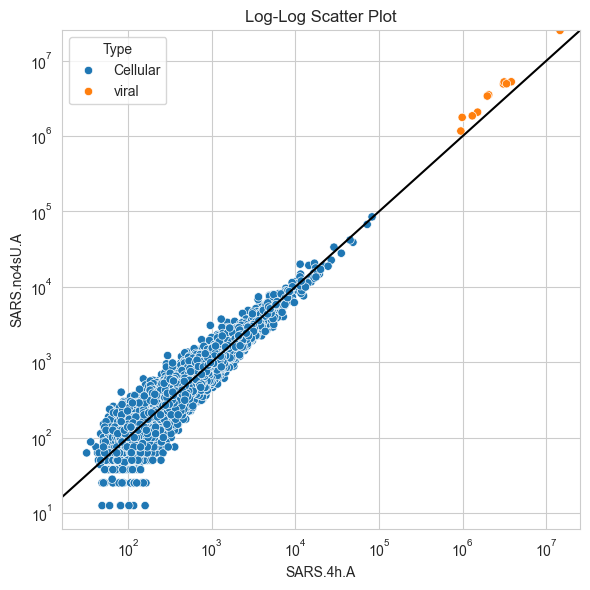

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=df,
    x='SARS.4h.A',
    y='SARS.no4sU.A',
    hue='Type'
)

plt.xscale('log')
plt.yscale('log')

lims = [
    np.min([df['SARS.4h.A'].min(), df['SARS.no4sU.A'].min()]),
    np.max([df['SARS.4h.A'].max(), df['SARS.no4sU.A'].max()]),
]
plt.plot(lims, lims, 'k-')
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel('SARS.4h.A')
plt.ylabel('SARS.no4sU.A')
plt.title('Log-Log Scatter Plot')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

Finally, it is also straight-forward to get summarized values across samples or cells from the same `Condition`:

In [27]:
sars.get_table(summarize = sars.get_summary_matrix())

,Mock,SARS
Symbol,,
MIB2,127.191705,2.199788e+02
OSBPL9,420.713293,3.862391e+02
BTF3L4,438.737953,3.861610e+02
ZFYVE9,147.462722,1.936313e+02
PRPF38A,340.765188,3.166291e+02
...,...,...
MECP2,641.771614,8.118211e+02
FLNA,22415.544725,1.594987e+04
DNASE1L1,271.944116,2.324657e+02


This is accomplished by a "summerize matrix":

In [28]:
smat = sars.get_summary_matrix()
smat

,Mock,SARS
Mock.no4sU.A,0.0,0.0
Mock.1h.A,0.2,0.0
Mock.2h.A,0.2,0.0
Mock.2h.B,0.2,0.0
Mock.3h.A,0.2,0.0
Mock.4h.A,0.2,0.0
SARS.no4sU.A,0.0,0.0
SARS.1h.A,0.0,0.2
SARS.2h.A,0.0,0.2
SARS.2h.B,0.0,0.2


Instead of specifying `True` for the `summarize` parameter, you can also specify such a matrix:

In [29]:
sars.get_table(summarize = smat)

,Mock,SARS
Symbol,,
MIB2,127.191705,2.199788e+02
OSBPL9,420.713293,3.862391e+02
BTF3L4,438.737953,3.861610e+02
ZFYVE9,147.462722,1.936313e+02
PRPF38A,340.765188,3.166291e+02
...,...,...
MECP2,641.771614,8.118211e+02
FLNA,22415.544725,1.594987e+04
DNASE1L1,271.944116,2.324657e+02


For summarization, the summarize matrix is matrix-multiplied with the raw matrix. `get_summarized_matrix()` will generate a matrix with columns corresponding to `Condition` s:

In [30]:
print(sars.condition)

['Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'SARS', 'SARS', 'SARS', 'SARS', 'SARS', 'SARS']


By default, no4sU columns are removed (i.e. zero in the matrix), but the `no4sU` parameter can change this:

In [31]:
sars.get_summary_matrix(no4su = True)

,Mock,SARS
Mock.no4sU.A,0.166667,0.000000
Mock.1h.A,0.166667,0.000000
Mock.2h.A,0.166667,0.000000
Mock.2h.B,0.166667,0.000000
Mock.3h.A,0.166667,0.000000
Mock.4h.A,0.166667,0.000000
SARS.no4sU.A,0.000000,0.166667
SARS.1h.A,0.000000,0.166667
SARS.2h.A,0.000000,0.166667
SARS.2h.B,0.000000,0.166667


It is also possible to focus on specific columns (sampels or cells) only:

In [32]:
sars.get_summary_matrix(columns = sars.coldata["duration.4sU"] < 4)

,Mock,SARS
Mock.no4sU.A,0.00,0.00
Mock.1h.A,0.25,0.00
Mock.2h.A,0.25,0.00
Mock.2h.B,0.25,0.00
Mock.3h.A,0.25,0.00
Mock.4h.A,0.00,0.00
SARS.no4sU.A,0.00,0.00
SARS.1h.A,0.00,0.25
SARS.2h.A,0.00,0.25
SARS.2h.B,0.00,0.25


The default behaviour is to compute the average, this can be changed to computing sums:

In [33]:
sars.get_summary_matrix(average = False)

,Mock,SARS
Mock.no4sU.A,0.0,0.0
Mock.1h.A,1.0,0.0
Mock.2h.A,1.0,0.0
Mock.2h.B,1.0,0.0
Mock.3h.A,1.0,0.0
Mock.4h.A,1.0,0.0
SARS.no4sU.A,0.0,0.0
SARS.1h.A,0.0,1.0
SARS.2h.A,0.0,1.0
SARS.2h.B,0.0,1.0


As a final example, to get averaged normalized values for the 2h timepoint only:

In [34]:
sars.get_table(summarize = sars.get_summary_matrix(columns = sars.coldata["duration.4sU"] == 2))

,Mock,SARS
Symbol,,
MIB2,126.481908,2.327461e+02
OSBPL9,426.994821,4.175073e+02
BTF3L4,424.395414,3.586589e+02
ZFYVE9,158.125547,1.897059e+02
PRPF38A,350.327840,3.380146e+02
...,...,...
MECP2,620.805345,7.874130e+02
FLNA,23090.731586,1.486973e+04
DNASE1L1,267.684953,2.264091e+02


# get_data
`get_data` is the "little cousin" of `get_table`: It returns a data frame with the samples or cells as rows and slot data, for either a singel gen or very few genes:

In [35]:
sars.get_data(genes = "MYC")

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU,MYC
Symbol,,,,,,,
Mock.no4sU.A,Mock.no4sU.A,Mock,0.0,no4sU,A,True,1546.603063
Mock.1h.A,Mock.1h.A,Mock,1.0,1h,A,False,1577.626303
Mock.2h.A,Mock.2h.A,Mock,2.0,2h,A,False,2543.484978
Mock.2h.B,Mock.2h.B,Mock,2.0,2h,B,False,1927.771241
Mock.3h.A,Mock.3h.A,Mock,3.0,3h,A,False,2127.583927
Mock.4h.A,Mock.4h.A,Mock,4.0,4h,A,False,2048.381231
SARS.no4sU.A,SARS.no4sU.A,SARS,0.0,no4sU,A,True,3430.879383
SARS.1h.A,SARS.1h.A,SARS,1.0,1h,A,False,2230.933733
SARS.2h.A,SARS.2h.A,SARS,2.0,2h,A,False,5206.511539


Note that by default, the `Coldata` table is also added (for more column-metadata, see the [loading data notebook](notebook_03_loading_data_and_working_with_grandPy_objects.ipynb)). Note that in contrast to `get_table`, where you can add the `gene_info` table, i.e. gene metadta, here it is the columns metadata! This can be changed by using the `coldata` parameter:

In [36]:
sars.get_data(genes = "MYC", with_coldata = False)

,MYC
Symbol,
Mock.no4sU.A,1546.603063
Mock.1h.A,1577.626303
Mock.2h.A,2543.484978
Mock.2h.B,1927.771241
Mock.3h.A,2127.583927
Mock.4h.A,2048.381231
SARS.no4sU.A,3430.879383
SARS.1h.A,2230.933733
SARS.2h.A,5206.511539


It is also possible to retrieve data for multiple genes and/or multiple slots and to restrict the columns:

In [37]:
sars.get_data(genes = ["MYC", "SRSF6"], columns = sars.coldata["Condition"] == "Mock", with_coldata = False)

,MYC,SRSF6
Symbol,,
Mock.no4sU.A,1546.603063,1327.982770
Mock.1h.A,1577.626303,1193.393522
Mock.2h.A,2543.484978,1220.125732
Mock.2h.B,1927.771241,1426.428652
Mock.3h.A,2127.583927,1208.633661
Mock.4h.A,2048.381231,1157.641602


In [38]:
sars.get_data(mode_slot = [("new_norm"), ("old_norm")], genes = "MYC", columns = sars.coldata["Condition"] == "Mock", with_coldata = False, ntr_nan = False)

,MYC_new_norm,MYC_old_norm
Symbol,,
Mock.no4sU.A,NaN,NaN
Mock.1h.A,979.232646,598.393657
Mock.2h.A,2543.484978,0.000000
Mock.2h.B,1927.771241,0.000000
Mock.3h.A,2127.583927,0.000000
Mock.4h.A,2048.381231,0.000000


In [39]:
sars.get_data(mode_slot = [("count"), ("norm")], genes = ["MYC", "SRSF6"], columns = sars.coldata["Condition"] == "Mock", with_coldata = False)

,MYC_count,SRSF6_count,MYC_norm,SRSF6_norm
Symbol,,,,
Mock.no4sU.A,428.0000,367.5000,1546.603063,1327.982770
Mock.1h.A,4768.3333,3607.0000,1577.626303,1193.393522
Mock.2h.A,6196.5000,2972.5000,2543.484978,1220.125732
Mock.2h.B,4422.0000,3272.0000,1927.771241,1426.428652
Mock.3h.A,8356.8333,4747.3333,2127.583927,1208.633661
Mock.4h.A,6723.0000,3799.5000,2048.381231,1157.641602


Finally, it is also possible to append multiple genes (and/or slots) not as columns, but as additional rows:

In [40]:
sars.get_data(genes = ["MYC", "SRSF6"], columns = sars.coldata["duration.4sU"] < 2, by_rows = True)

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU,Gene,Value,Slot
0,Mock.no4sU.A,Mock,0.0,no4sU,A,True,MYC,1546.603063,norm
1,Mock.1h.A,Mock,1.0,1h,A,False,MYC,1577.626303,norm
2,SARS.no4sU.A,SARS,0.0,no4sU,A,True,MYC,3430.879383,norm
3,SARS.1h.A,SARS,1.0,1h,A,False,MYC,2230.933733,norm
4,Mock.no4sU.A,Mock,0.0,no4sU,A,True,SRSF6,1327.982770,norm
5,Mock.1h.A,Mock,1.0,1h,A,False,SRSF6,1193.393522,norm
6,SARS.no4sU.A,SARS,0.0,no4sU,A,True,SRSF6,2372.816215,norm
7,SARS.1h.A,SARS,1.0,1h,A,False,SRSF6,1616.432049,norm


This can be quite helpful, as for the following example: We retrieve total, old new RNA for SRSF6 (only replicate A), and do this by rows. This way, the data can directly be used for mathplotlib/seaborn to plot the progressive labeling time course (note the much shorter half-life, which is the time where the new and old lines cross, for SARS as compared to Mock):

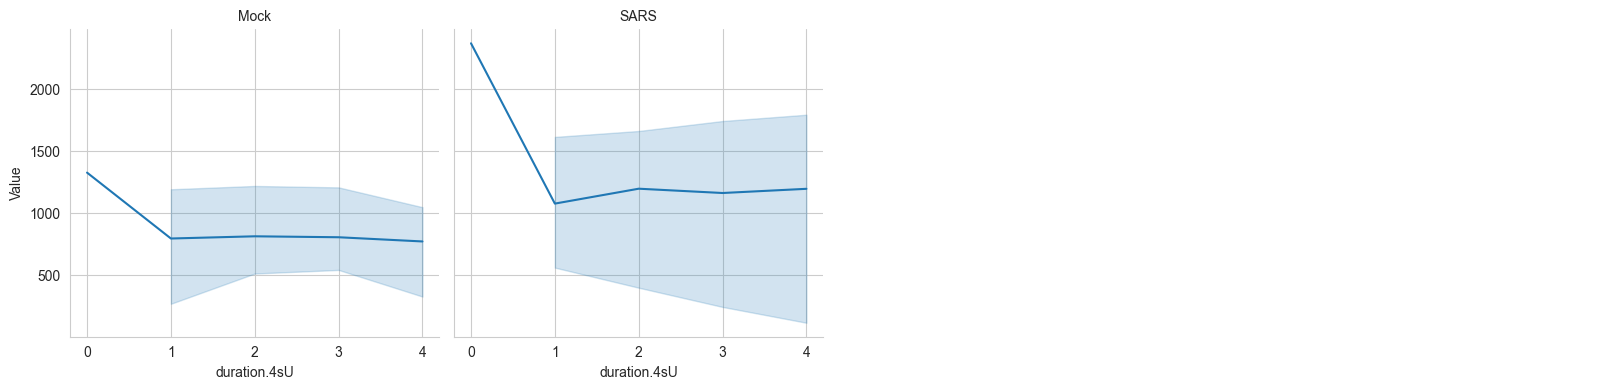

In [42]:
df = sars.get_data(mode_slot = ["old_norm", "new_norm", "total_norm"], genes = "SRSF6",
                   columns = sars.coldata["Replicate"] == "A", by_rows = True)

g = sns.FacetGrid(df, col= "Condition", col_wrap=4, height=4, sharey=True)

g.map(sns.lineplot, 'duration.4sU', 'Value')

g.add_legend()
g.set_axis_labels("duration.4sU", "Value")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

# get_analysis_table
`get_analysis_table` 